In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('Time_series/sp500_index.csv')
data.head()

,Date,S&P500
0,2014-11-14,2039.82
1,2014-11-17,2041.32
2,2014-11-18,2051.80
3,2014-11-19,2048.72
4,2014-11-20,2052.75


In [3]:
data['Date'] = pd.to_datetime(data['Date'])

#data = data[(data['Date'].dt.year >= 2020) & (data['Date'].dt.year <= 2024)]

In [4]:
print(data.shape)
print(data.dtypes)

(2516, 2)
Date      datetime64[ns]
S&P500           float64
dtype: object


In [5]:
data.isnull().values.any()

False

In [6]:
data.describe()

,Date,S&P500
count,2516,2516.000000
mean,2019-11-15 08:08:12.209857024,3306.061514
min,2014-11-14 00:00:00,1829.080000
25%,2017-05-16 18:00:00,2394.335000
50%,2019-11-13 12:00:00,2976.305000
75%,2022-05-13 18:00:00,4173.187500
max,2024-11-13 00:00:00,6001.350000
std,NaN,1051.392705


### Exploratory Data Analysis

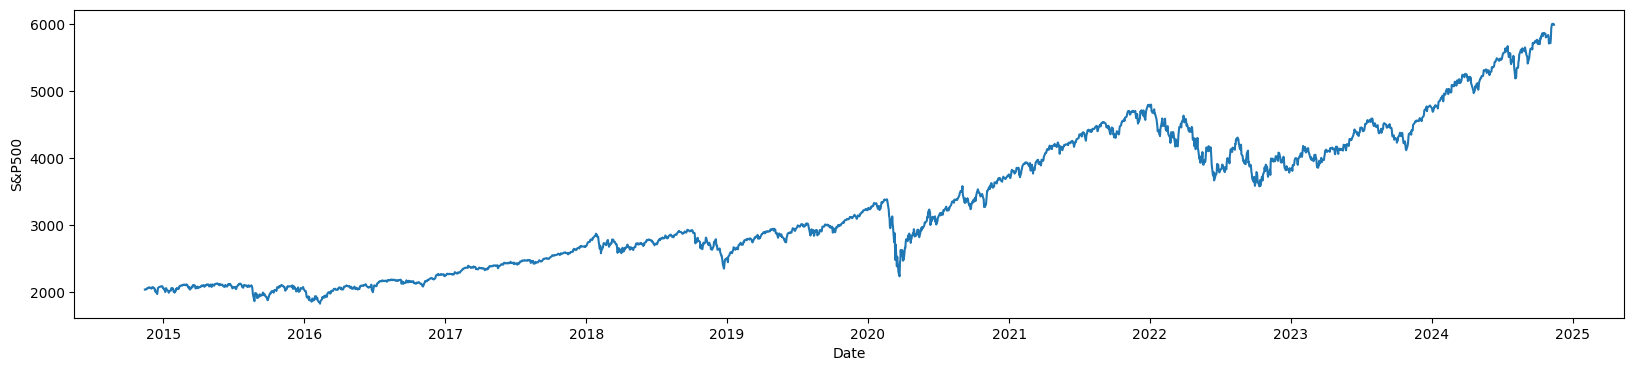

In [7]:
# plot car count over all years
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])
plt.show()

Abbiamo osservato che nel 2020 c'è un forte picco verso il basso che altera la tendenza nei dati. Analizziamo successivamente in dettaglio cosa succede

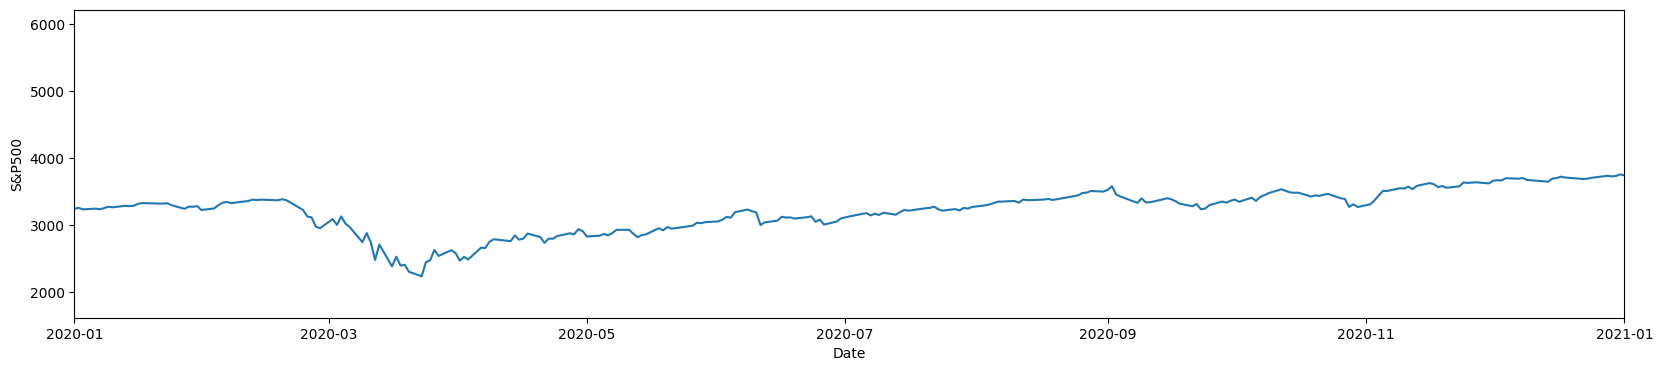

In [8]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

Si può notare che il grande picco verso il basso si può ricollegare all'inizio del COVID, nei mesi di marzo aprile 2020. Successivamente si nota una graduale ripresa

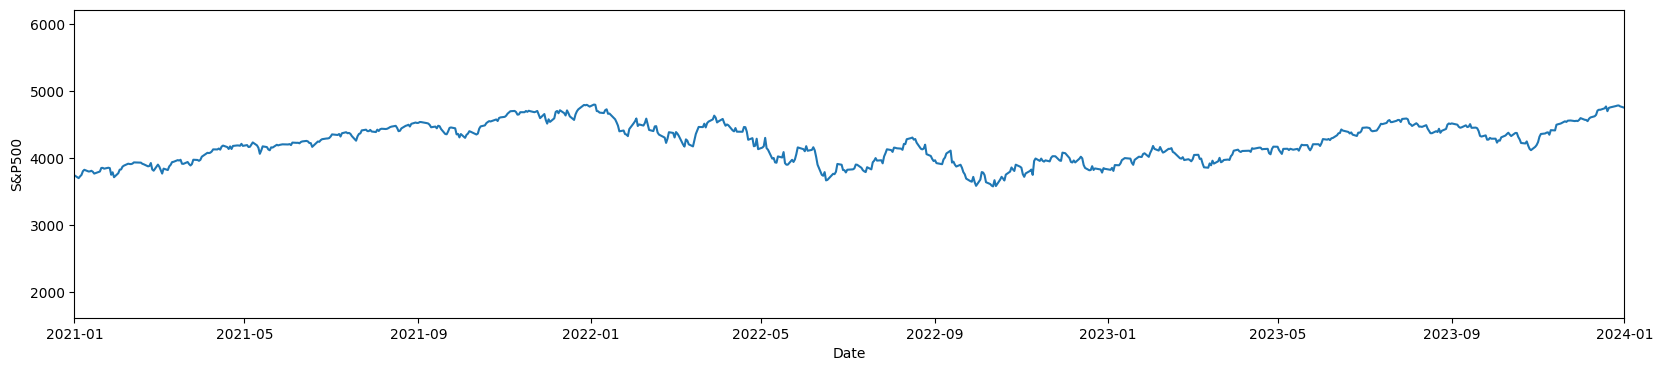

In [9]:
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2024,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

un altro momento di picco verso il basso si ha ad inizio 2022 fino al 2023, ricollegabile alla difficile situazione geopolitica tra russia e ucraina

In [10]:
# Rimuovi i dati dal 2020-01-01 al 2020-05-31
#data_filter = data[~((data['Date'] >= '2020-01-01') & (data['Date'] <= '2020-05-31'))]

# Rimuovi dati da anni precedenti al 2022 o successivi al 2023
#data_new = data_filter[~((data_filter['Date'] >= '2022-01-01') & (data_filter['Date'] <= '2023-01-01'))]

data_new = data

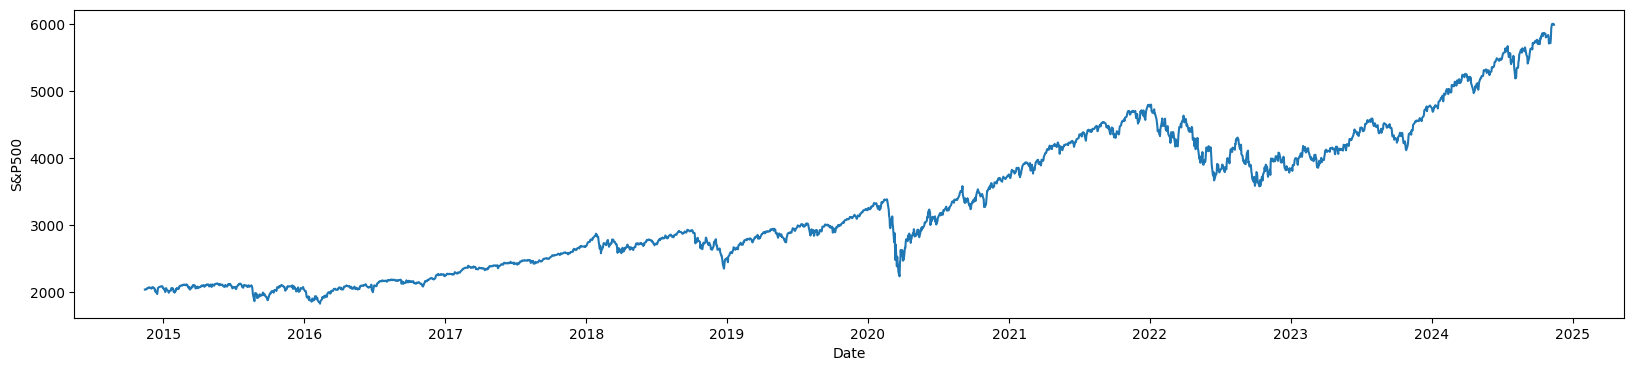

In [11]:
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data_new['Date'], data_new['S&P500'])
plt.show()

## Forecasting

### Stationarity

In [12]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value']
    df_test = adfuller(ts)
    df_results = pd.Series(df_test[0:2], index=stats)
    
    print('ADF statistic:', df_results.iloc[0])
    print('P-value:', df_results.iloc[1])

In [13]:
test_stationarity(data_new['S&P500'])

ADF statistic: 1.0111079961582905
P-value: 0.9943817790861783


In [14]:
(data_new['S&P500'] - data_new['S&P500'].shift(1)).head()

0      NaN
1     1.50
2    10.48
3    -3.08
4     4.03
Name: S&P500, dtype: float64

In [15]:
data_new['S&P500'].diff().head()

0      NaN
1     1.50
2    10.48
3    -3.08
4     4.03
Name: S&P500, dtype: float64

In [16]:
test_stationarity(data_new['S&P500'].diff().dropna())

ADF statistic: -10.26447819748796
P-value: 4.153723222461407e-18


### ACF and PACF graphs

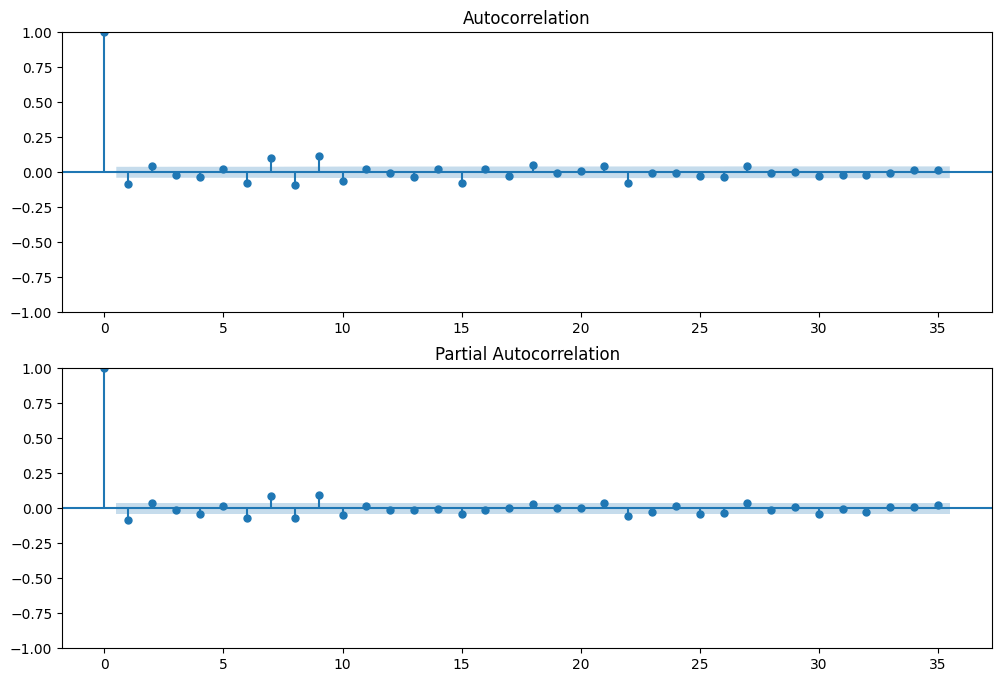

In [17]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_new['S&P500'].diff()[1:],  ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_new['S&P500'].diff()[1:], ax=ax2)

q=1 e p=2

### Fitting Model

                               SARIMAX Results                                
Dep. Variable:                 S&P500   No. Observations:                 2516
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -12642.244
Date:                Fri, 15 Nov 2024   AIC                          25292.487
Time:                        13:08:25   BIC                          25315.807
Sample:                             0   HQIC                         25300.951
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1600      0.244     -0.655      0.512      -0.638       0.318
ar.L2          0.0364      0.024      1.527      0.127      -0.010       0.083
ma.L1          0.0833      0.243      0.343      0.7

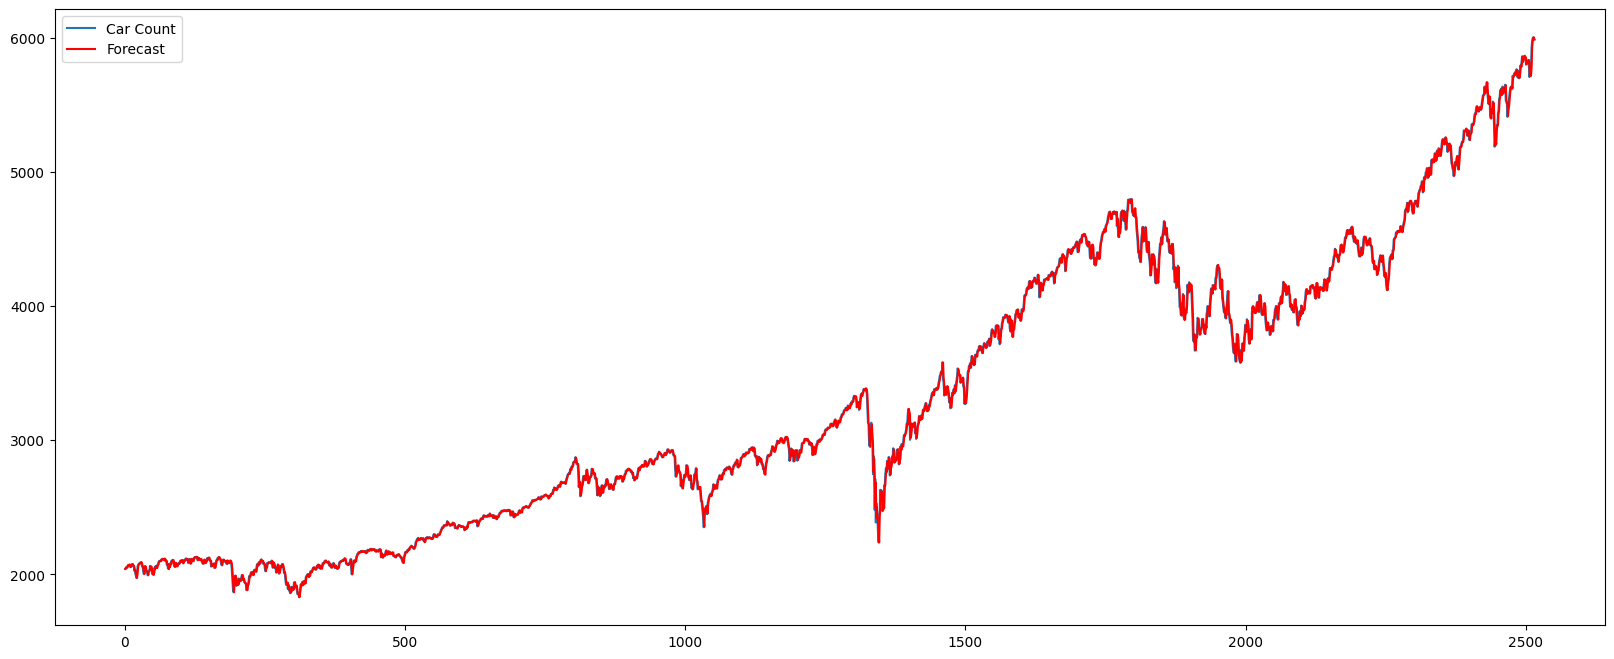

In [18]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(data_new['S&P500'], order=(2,1,1)) 
ax = plt.gca()
results = model.fit() 
plt.plot(data_new['S&P500'][1:])
plt.plot(results.fittedvalues[1:], color='red')
ax.legend(['Car Count', 'Forecast'])

print(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 S&P500   No. Observations:                 2516
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12607.633
Date:                Fri, 15 Nov 2024   AIC                          25225.265
Time:                        13:10:51   BIC                          25254.415
Sample:                             0   HQIC                         25235.845
                               - 2516                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7646      0.020    -86.403      0.000      -1.805      -1.725
ar.L2         -0.8829      0.019    -45.563      0.000      -0.921      -0.845
ma.L1          1.7003      0.025     67.499      0.000       1.651       1.750
ma.L2          0.8009      0.024     33.238      0.000       0.754       0.848
sigma2      1323.4432     20.601     64.243      0.000    1283.066    1363.820
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):              3589.46
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               7.08   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

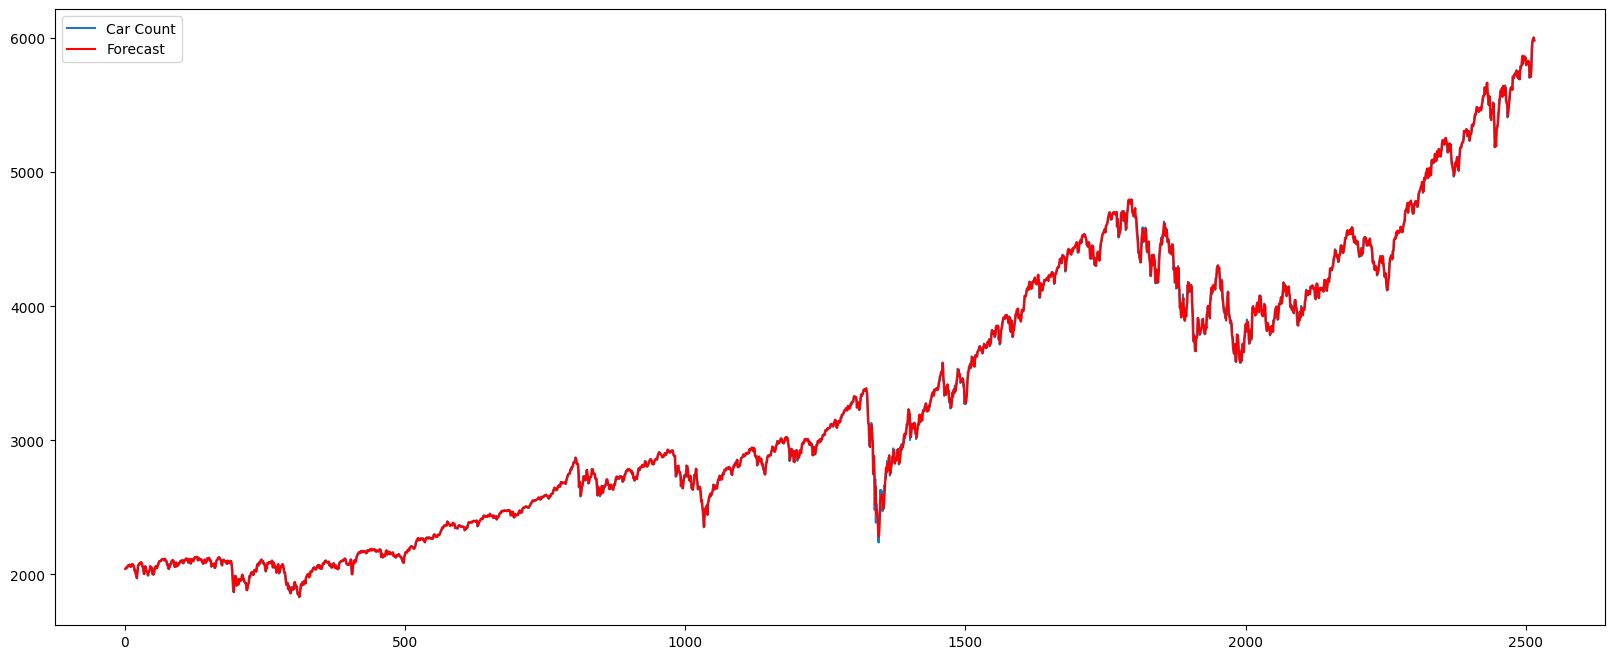

In [22]:
fig = plt.figure(figsize=(20,8))
model = ARIMA(data_new['S&P500'], order=(2,1,2)) 
ax = plt.gca()
results = model.fit() 
plt.plot(data_new['S&P500'][1:])
plt.plot(results.fittedvalues[1:], color='red')
ax.legend(['Car Count', 'Forecast'])

results.summary()

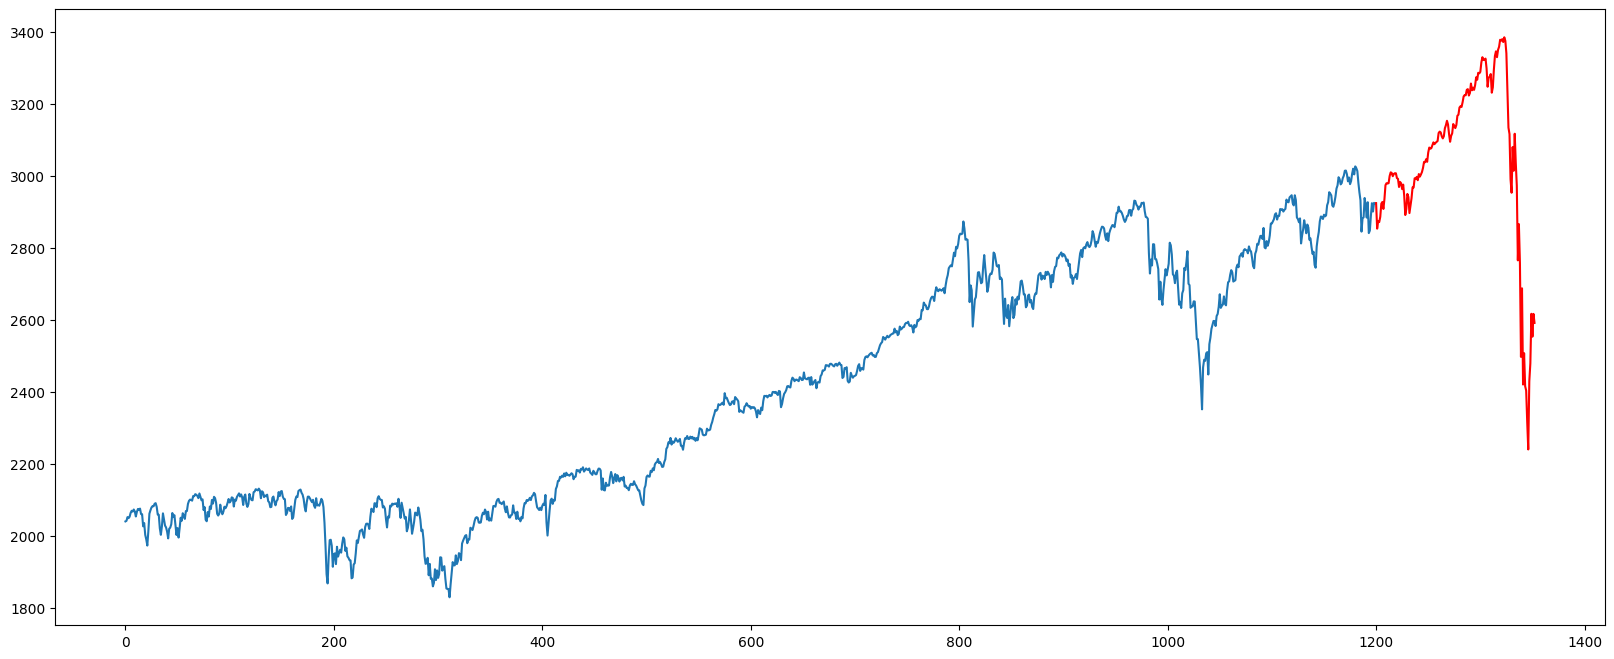

In [20]:
fig = plt.figure(figsize=(20,8))
num_points = len(data_new['S&P500'])
x = results.predict(start=(1200), end=(1352), dynamic=False)

plt.plot(data_new['S&P500'][:1200])
plt.plot(x, color='r')

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Caricamento dati
# Assicurati che 'df_monthly' sia il tuo dataframe con colonne Date e S&P500
#df_monthly['Date'] = pd.to_datetime(df_monthly['Date'], format='%Y/%m')
#df_monthly.set_index('Date', inplace=True)

# Se i dati non sono stazionari, applica differenze per rendere i dati stazionari
# Questo può essere fatto anche automaticamente da auto_arima

# Trova automaticamente il miglior modello SARIMA con auto_arima
m = 12 # Provare a lavorare con questo 
model = auto_arima(data_new['S&P500'], seasonal=False, stepwise=True, trace=True)

# Stampa i parametri del miglior modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25222.178, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25304.973, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25289.881, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25291.224, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25307.489, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25289.343, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25289.576, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25223.827, Time=1.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25290.070, Time=1.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25288.600, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=25288.892, Time=0.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25289.532, Time=0.74 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25224.817, Time=1.57 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=25225.265, Time=0.53 sec

Best model:  ARIMA

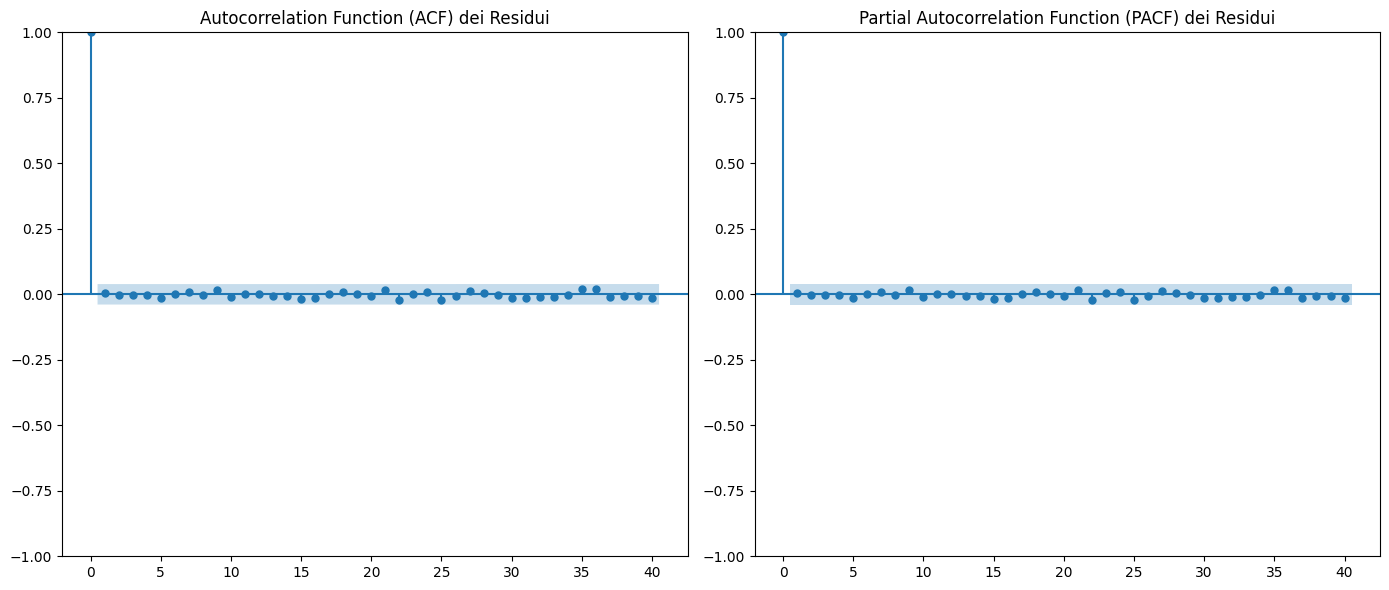

In [25]:
# Previsione dei residui
residuals = model.resid()


# Previsione dei residui
residuals = model.resid()


# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()